### tensorflow로 Object Detection 수행하기 

#### 단일 이미지 Object Detection

image shape: (633, 806, 3)


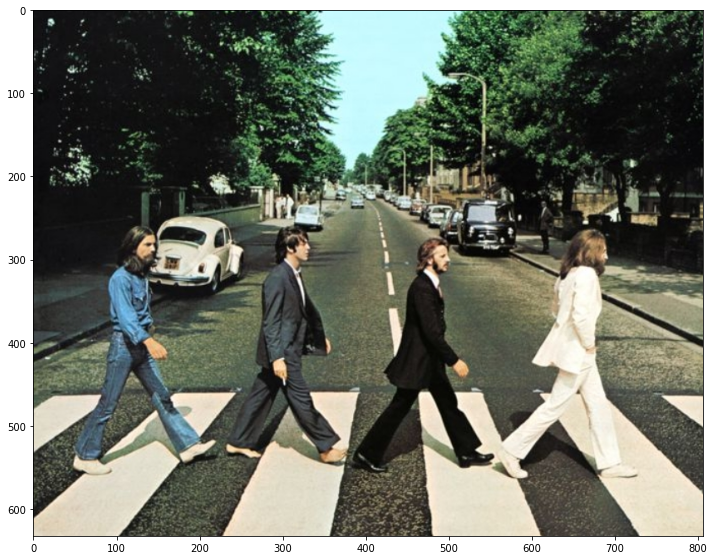

In [1]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

img = cv2.imread('../../data/image/beatles01.jpg')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

print('image shape:', img.shape)
plt.figure(figsize=(12, 12))
plt.imshow(img_rgb)

In [2]:
labels_to_names = {1:'person',2:'bicycle',3:'car',4:'motorcycle',5:'airplane',6:'bus',7:'train',8:'truck',9:'boat',10:'traffic light',
                    11:'fire hydrant',12:'street sign',13:'stop sign',14:'parking meter',15:'bench',16:'bird',17:'cat',18:'dog',19:'horse',20:'sheep',
                    21:'cow',22:'elephant',23:'bear',24:'zebra',25:'giraffe',26:'hat',27:'backpack',28:'umbrella',29:'shoe',30:'eye glasses',
                    31:'handbag',32:'tie',33:'suitcase',34:'frisbee',35:'skis',36:'snowboard',37:'sports ball',38:'kite',39:'baseball bat',40:'baseball glove',
                    41:'skateboard',42:'surfboard',43:'tennis racket',44:'bottle',45:'plate',46:'wine glass',47:'cup',48:'fork',49:'knife',50:'spoon',
                    51:'bowl',52:'banana',53:'apple',54:'sandwich',55:'orange',56:'broccoli',57:'carrot',58:'hot dog',59:'pizza',60:'donut',
                    61:'cake',62:'chair',63:'couch',64:'potted plant',65:'bed',66:'mirror',67:'dining table',68:'window',69:'desk',70:'toilet',
                    71:'door',72:'tv',73:'laptop',74:'mouse',75:'remote',76:'keyboard',77:'cell phone',78:'microwave',79:'oven',80:'toaster',
                    81:'sink',82:'refrigerator',83:'blender',84:'book',85:'clock',86:'vase',87:'scissors',88:'teddy bear',89:'hair drier',90:'toothbrush',
                    91:'hair brush'}

In [3]:
# !mkdir pretrained; cd pretrained
# !wget http://download.tensorflow.org/models/object_detection/faster_rcnn_resnet50_coco_2018_01_28.tar.gz
# !wget https://raw.githubusercontent.com/opencv/opencv_extra/master/testdata/dnn/faster_rcnn_resnet50_coco_2018_01_28.pbtxt
# cd faster_rcnn_resnet50_coco_2018_01_28; mv faster_rcnn_resnet50_coco_2018_01_28.pbtxt config.pbtxt

Instructions for updating:
Use tf.gfile.GFile.
type of out:  <class 'list'> length of out :  4
[array([19.], dtype=float32), array([[0.99975055, 0.99930644, 0.99804664, 0.9970788 , 0.92220104,
        0.8515701 , 0.80553705, 0.73219806, 0.7169087 , 0.6350255 ,
        0.60577285, 0.54820275, 0.512524  , 0.4640813 , 0.43892688,
        0.41287604, 0.4075497 , 0.39610362, 0.31717572, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0. 

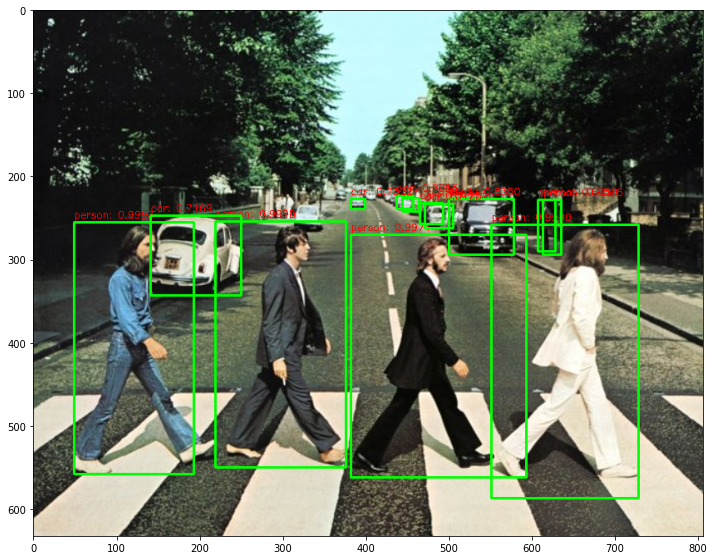

In [4]:
import numpy as np
import tensorflow as tf
import cv2
import time
import matplotlib.pyplot as plt
%matplotlib inline

# inference graph를 읽음
with tf.gfile.FastGFile("./pretained/faster_rcnn_resnet50_coco_2018_01_28/frozen_inference_graph.pb", "rb") as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())

with tf.Session() as sess:
    # Session 시작하고 inference graph 모델 로딩
    sess.graph.as_default()
    tf.import_graph_def(graph_def, name="")

    img = cv2.imread("../../data/image/beatles01.jpg")
    draw_img = img.copy()
    rows = img.shape[0]
    cols = img.shape[1]
    inp = img[:,:,[2,1,0]]
    start = time.time()
    # Object detection 수행
    out = sess.run([sess.graph.get_tensor_by_name("num_detections:0"),
                    sess.graph.get_tensor_by_name("detection_scores:0"),
                    sess.graph.get_tensor_by_name("detection_boxes:0"),
                    sess.graph.get_tensor_by_name("detection_classes:0")],
                    feed_dict={"image_tensor:0":inp.reshape(1, inp.shape[0], inp.shape[1], 3)})
    print("type of out: ",type(out), "length of out : ", len(out))
    print(out)
    green_color = (0,255,0)
    red_color = (0,0,255)

    # Bounding box 시각화
    num_detections = int(out[0][0])
    for i in range(num_detections):
        classId = int(out[3][0][i])
        score = float(out[1][0][i])
        bbox = [float(v) for v in out[2][0][i]]
        if score > 0.5:
            left = bbox[1] * cols
            top = bbox[0] * rows
            right = bbox[3] * cols
            bottom = bbox[2] * rows
            cv2.rectangle(draw_img, (int(left), int(top)), (int(right), int(bottom)), green_color, thickness=2)
            caption = "{}: {:.4f}".format(labels_to_names[classId], score)
            print(caption)
            cv2.putText(draw_img, caption, (int(left), int(top-5)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, red_color, 1)
    print("Detection 수행 시간: ",round(time.time() - start,2),"초")

img_rgb = cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12,12))
plt.imshow(img_rgb)


In [5]:
def get_tensor_detected_image(sess, img_array, use_copied_array):
    
    rows = img_array.shape[0]
    cols = img_array.shape[1]
    if use_copied_array:
        draw_img_array = img_array.copy()
    else:
        draw_img_array = img_array
    
    inp = img_array[:, :, [2, 1, 0]]  # BGR2RGB

    start = time.time()
    # Object Detection 수행. 
    out = sess.run([sess.graph.get_tensor_by_name('num_detections:0'),
                    sess.graph.get_tensor_by_name('detection_scores:0'),
                    sess.graph.get_tensor_by_name('detection_boxes:0'),
                    sess.graph.get_tensor_by_name('detection_classes:0')],
                   feed_dict={'image_tensor:0': inp.reshape(1, inp.shape[0], inp.shape[1], 3)})
    
    green_color=(0, 255, 0)
    red_color=(0, 0, 255)
    
    # Bounding Box 시각화 
    num_detections = int(out[0][0])
    for i in range(num_detections):
        classId = int(out[3][0][i])
        score = float(out[1][0][i])
        bbox = [float(v) for v in out[2][0][i]]
        if score > 0.5:
            left = bbox[1] * cols
            top = bbox[0] * rows
            right = bbox[3] * cols
            bottom = bbox[2] * rows
            cv2.rectangle(draw_img_array, (int(left), int(top)), (int(right), int(bottom)), green_color, thickness=2)
            caption = "{}: {:.4f}".format(labels_to_names[classId], score)
            cv2.putText(draw_img_array, caption, (int(left), int(top - 5)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, red_color, 1)
            #print(caption)
    print('Detection 수행시간:',round(time.time() - start, 2),"초")
    return draw_img_array
# end of function

#inference graph를 읽음. 
with tf.gfile.FastGFile('./pretrained/faster_rcnn_resnet50_coco_2018_01_28/frozen_inference_graph.pb', 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    
with tf.Session() as sess:
    # Session 시작하고 inference graph 모델 로딩 
    sess.graph.as_default()
    tf.import_graph_def(graph_def, name='')
    
    # 입력 이미지 생성 및 BGR을 RGB로 변경 
    img = cv2.imread('../../data/image/beatles01.jpg')
    draw_img = get_tensor_detected_image(sess, img, True)

img_rgb = cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 12))
plt.imshow(img_rgb)

#### tensorflow로 video Object Detection 수행

In [ ]:
video_input_path = '../../data/video/John_Wick_small.mp4'
# linux에서 video output의 확장자는 반드시 avi 로 설정 필요. 
video_output_path = '../../data/output/John_Wick_small_tensor01.avi'

cap = cv2.VideoCapture(video_input_path)

codec = cv2.VideoWriter_fourcc(*'XVID')

vid_size = (round(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),round(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
vid_fps = cap.get(cv2.CAP_PROP_FPS)
    
vid_writer = cv2.VideoWriter(video_output_path, codec, vid_fps, vid_size) 

frame_cnt = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print('총 Frame 갯수:', frame_cnt)

green_color=(0, 255, 0)
red_color=(0, 0, 255)

#inference graph를 읽음. .
with tf.gfile.FastGFile('./pretrained/faster_rcnn_resnet50_coco_2018_01_28/frozen_inference_graph.pb', 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    
with tf.Session() as sess:
    # Session 시작하고 inference graph 모델 로딩 
    sess.graph.as_default()
    tf.import_graph_def(graph_def, name='')

    while True:
        hasFrame, img_frame = cap.read()
        if not hasFrame:
            print('더 이상 처리할 frame이 없습니다.')
            break

        draw_img_frame = get_tensor_detected_image(sess, img_frame, False)
        vid_writer.write(draw_img_frame)
    # end of while loop

vid_writer.release()
cap.release()  


In [ ]:
!gsutil cp ../../data/output/John_Wick_small_tensor01.avi gs://my_bucket_dlcv/data/output/John_Wick_small_tensor01.avi